In [3]:
%matplotlib inline
import pylab
import matplotlib.pyplot as plt
import glob

import shapely as sl
import shapely.geometry
import fiona

import gee
from utils.shapely_plot import draw

pylab.rcParams['figure.figsize'] = (20.0, 15.0)

path_basins = glob.glob(r'..\data\HydroBASINS\without_lakes\hybas_au_lev*_v1c.shp')
path_river = r'..\data\HydroBASINS\rivers\au_riv_15s.shp'

In [4]:
from utils.shapely_plot import draw

### Load HydroBASINS for Australia, Murray River basin

In [5]:
def draw_basins_and_rivers(max_basin_id, selected_basin_id, up_cells=10000, max_level=3, selected_level=3, max_up=-1):
    """Draws basin boundaries and rivers

    Keyword arguments:
    max_basin_id -- TODO
    selected_basin_id -- TODO
    ...
    """
    selected_basin_geom = None
    
    with fiona.collection(path_basins[max_level], "r") as shp:
        for feature in shp: 
            pfaf_id = feature['properties']['PFAF_ID'] 
            if str(pfaf_id).startswith(str(max_basin_id)): 
                geom = sl.geometry.shape(feature['geometry'])
                draw(geom)

    with fiona.collection(path_basins[selected_level], "r") as shp:
        for feature in shp: 
            pfaf_id = feature['properties']['PFAF_ID'] 
            if pfaf_id == selected_basin_id:
                geom = sl.geometry.shape(feature['geometry'])
                draw(geom, fill='#aaaaff')
                selected_basin_geom = geom
                
    with fiona.collection(path_river, "r") as shp:
        for feature in shp: 
            up = feature['properties']['UP_CELLS']
            if up > up_cells:
                geom = sl.geometry.shape(feature['geometry'])
                if geom.envelope.intersects(selected_basin_geom.envelope) and geom.intersects(selected_basin_geom):
                    draw(geom, outline='#3333ff', lw=0.5)

C:\Anaconda\lib\site-packages\numba\dataflow.py:52: RuntimeWarning: inconsistent stack offset for block(offset:326, outgoing: [], incoming: [21, 61, 110, 323])
  RuntimeWarning)


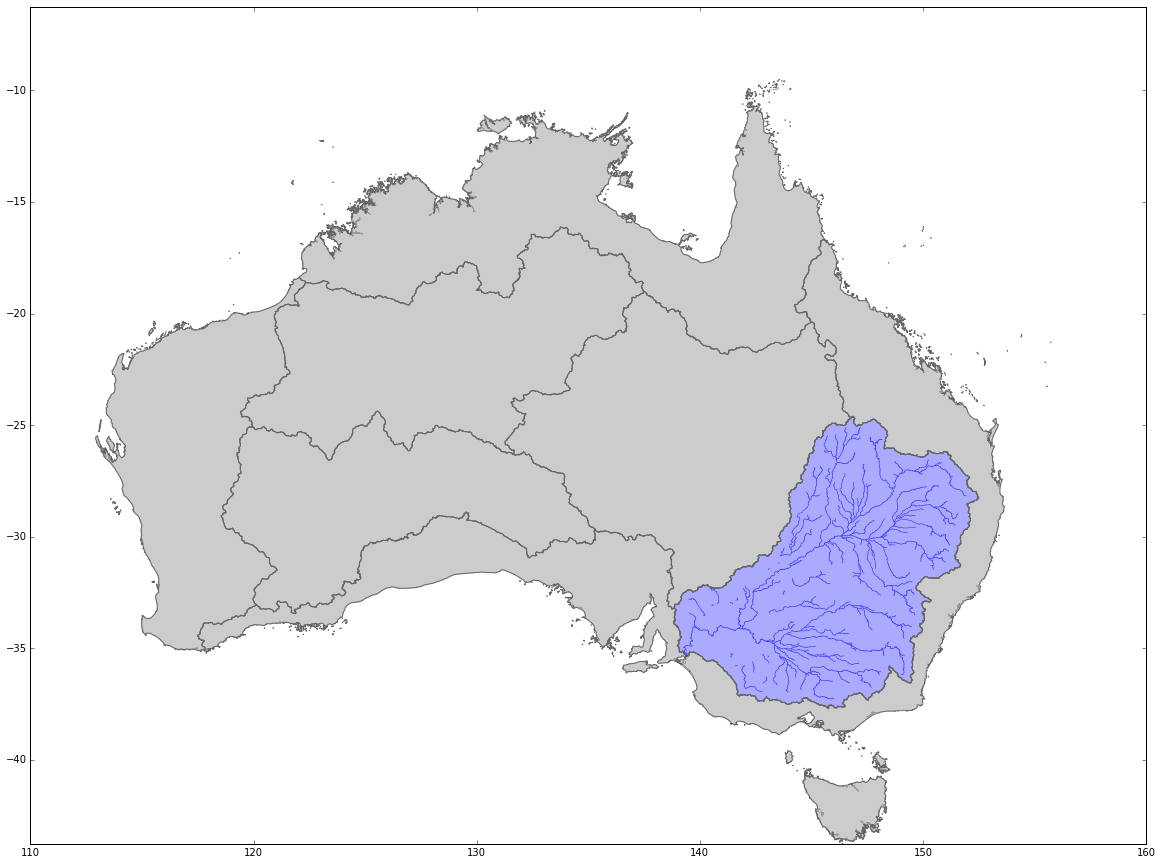

In [7]:
fig = plt.figure()
axes = plt.axes()
axes.set_aspect('equal', 'datalim')

draw_basins_and_rivers(56, 564) # Australia main basin, Murray

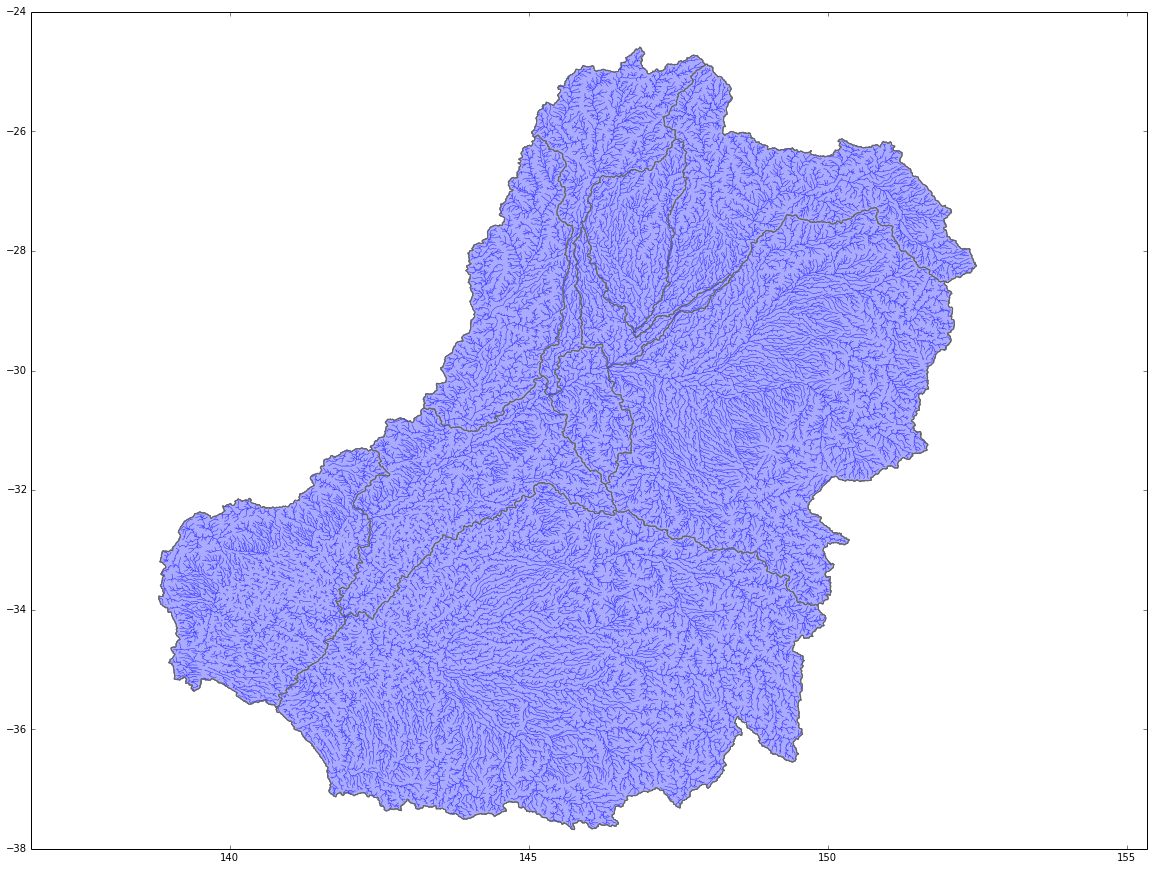

In [13]:
fig = plt.figure()
axes = plt.axes()
axes.set_aspect('equal', 'datalim')

draw_basins_and_rivers(564, 564, up_cells=0, max_level=4, selected_level=3, max_up=4237157) # Murray

### Extract water features from planet.osm (24GB) using river basins from HydroBASINS

- PBF --> SpatiaLite, show in QGIS using styles from https://github.com/anitagraser/QGIS-resources/tree/master/qgis2/osm_spatialite
- or using Overpass API: https://github.com/tyrasd/overpass-turbo
- Use HydroBASINS to clip OSM
- Select Pfefstetter levels to be used
- Extract water polylines and polygons
- Select appropriate water tags
- Fix topological errors

### Upload water vector features to Google Fusion Table
- Convert SpatiaLite to KML (or directly from PBF)
- Upload results to Google Fusion Table

### Compare OSM and HydroSHEDS rivers

### Cloud cover, %

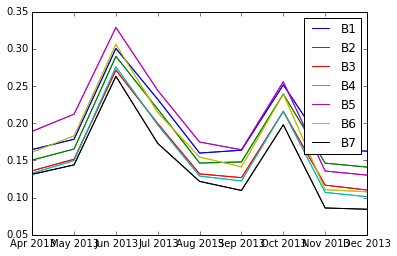

In [1]:
import ee
import matplotlib.pyplot as plt
import datetime

ee.Initialize() 

sanFrancisco = ee.Geometry.Rectangle(-122.45, 37.74, -122.4, 37.8)
landsat8Toa = ee.ImageCollection('LANDSAT/LC8_L1T_32DAY_TOA').filterDate('2012-12-25', '2013-12-25').select('B[1-7]')

def getMean(img):
    return img.reduceRegions(sanFrancisco, ee.Reducer.mean()
                             .forEachBand(img),200).makeArray(['B{0}'.format(x) for x in range(1,8)],'values')
ans = ee.FeatureCollection(landsat8Toa.map(getMean)).flatten().aggregate_array('.all').getInfo()

data = [x['properties']['values'] for x in ans]
x_ = range(0,7)
labels = ['B{0}'.format(x) for x in range(1,8)]

plt.plot(data)
plt.xticks(range(len(plt.xticks()[0])),[datetime.datetime.strptime(x['id'][:-2], "%Y%m%d").strftime('%b %Y') for x in ans])
plt.legend(plt.plot(data),['B{0}'.format(x) for x in range(1,8)])
plt.show()


In [2]:
image = ee.Image('srtm90_v4')
crs = image.getInfo()['bands'][0]['crs']

# Use the image's CRS when getting a thumbnail of the ImageCollection.
thumb = image.getThumbUrl({
  'crs': crs,
  'region': [[114.845,6.842],[114.845,4.735],[116.91,4.735],[116.91,6.842]],
  'format': 'png',
  'min': 0,
  'max': 1000,
  'size': '800'
})

In [4]:
print(thumb)

https://earthengine.googleapis.com//api/thumb?thumbid=0771038ad9e87f8480213db35e79fd60&token=1091d989f78e1d9d10a8f3f0b5b95d72


In [3]:
from IPython.display import Image
Image(url=thumb) 


### Detect threshold for NDWI using OpenStreetMap polygons as a hint

### Maximum and minimum water pixels

### Compute goodness of fit
Hit rate (true-positives), FAR (false alarms / false-positives), error bias, see http://goo.gl/l4UFZH

- How well can we detect water using LANDSAT?
- How well OSM matches water mask from LANDSAT?

#### Metrices
- Shift along the stream
- Width of the stream (polyline vs. polygon)
- Broken rivers (parts are missing)
- Missing branches
- Too small or missing water (LANDSAT - false, OSM - true)?


### Convert results to polygons and merge with existing OSM
- Lakes
- Rivers as polygons
- Rivers as polylines (including topology?)
- Add tags based on existing OSM features